# Chest X-ray Medical Diagnosis with DenseNet121

 This project is a practice for CheXNet paper with also the reference on Coursera "AI for Medicine Dianosis". For details on the CheXNet Paper: [CheXNet](https://arxiv.org/abs/1711.05225)

We will be using the [ChestX-ray8 dataset](https://arxiv.org/abs/1705.02315) which contains 108,948 frontal-view X-ray images of 32,717 unique patients. 
- Each image in the data set contains multiple text-mined labels identifying 14 different pathological conditions. 
- These in turn can be used by physicians to diagnose 8 different diseases. 
- We will use this data to develop a single model that will provide binary classification predictions for each of the 14 labeled pathologies. 
- In other words it will predict 'positive' or 'negative' for each of the pathologies.
 
- Full dataset is [here](https://nihcc.app.box.com/v/ChestXray-NIHCC). We use the X-ray in the file "images_001.tar" with 4999 samples

Before you start, there are steps you should follow:
1. download and unzip the files in the directory `./images`
2. download `train_val_list.txt` and `test_list.txt` and `Data_Entry_2017*.csv`
3. run `csv_extractor` to combine the above information into one csv.file. The default ouput will be "my_list.csv".


## 1.Import Packages and Functions
utils.py provides utility functions. Feel free to check

In [ ]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from datetime import date
from utils import *
K.set_image_data_format('channels_last')

## 2.Define Basic Paramers & Data preparation
Some default settings are shown below.
For data normalization, we sample 1000 samples in the training set.
Data Leakaing check is used to double check no patient overlap between train_val and test set. 

In [0]:
#For faster speed, we lower the image size to 180 x 180 pixel.
#The batch size 64 is suitable for colab GPU
#replace with your image path
IMGDIR = './images'
IMG_H = 180
IMG_W = 180
batch_size = 64
#validation data ratio
val_split = 0.2

In [4]:
#Load csv file for the output of csv_extractor.py"
df = pd.read_csv('my_list.csv')
LABELS = list(df.keys())[:-5]
#Note that 'Is_tv' indicates wheather the data is for train_val set
df.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Patient ID,Patient Age,Patient Gender,Image,Is_tv
0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,1,57,M,00000001_000.png,True
1,False,True,False,False,False,True,False,False,False,False,False,False,False,False,1,58,M,00000001_001.png,True
2,False,True,False,False,True,False,False,False,False,False,False,False,False,False,1,58,M,00000001_002.png,True
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2,80,M,00000002_000.png,True
4,False,False,False,False,False,False,False,True,False,False,False,False,False,False,3,81,F,00000003_000.png,False


In [5]:
#leakage check
if leakage_check(df, 'Patient ID', 'Is_tv'):
    print('Leakage check pass :D')
else:
    print('Leakage check fail :(')
    exit()

Leakage check pass :D


In [6]:
#get mean and std of 1000 samples in train_val dataset, my result is provided.
np.random.seed(1)
#grab_mean_std = get_norm_data(df, image_dir = IMGDIR, H=IMG_H, W=IMG_W)
grab_mean_std = (132.17362, 64.707858362593)
print(f'Sampled mean, std is : {grab_mean_std[0]:.2f}, {grab_mean_std[1]:.2f}')

Sampled mean, std is : 132.17, 64.71


In [7]:
#get split array for cross-validation.
folds, most_n = get_split(df, val_split)
print(f"Validation Splits = {val_split}, Available folds for validation : {most_n}")
#Choose the the 0th folds. (Users can change the folds 0~4 for cross-validation) 
train_fold, val_fold = get_train_val_split(folds, 0)

Validation Splits = 0.2, Available folds for validation : 5


In [8]:
#get generator for train & val set
train_gen, val_gen = get_tv_generator(df, train_fold, val_fold, grab_mean_std, LABELS, IMGDIR, IMG_H, IMG_W, batch_size = batch_size)
N_train, N_val, N_test = len(train_gen.filenames), len(val_gen.filenames), len(df[df['Is_tv'] == False])
print(f"train, val, test samples : {N_train}, {N_val}, {N_test}")

Found 3226 validated image filenames.
Found 806 validated image filenames.
train, val, test samples : 3226, 806, 967


## 3.Expore the data
Expore the data form. Only the training data use data augmentation. (zoom = 0.1, rotation = 7, horizontal flip = True)

Note that there is class imbalance.
To deal with it, we will use weighted loss to compensate the negative part.

In [0]:
#get one batch from generator
x1, y1 = val_gen[0]
x2, y2 = train_gen[0]

Original images: (ony resized)
image shape: (64, 180, 180, 3)
label shape: (64, 14)


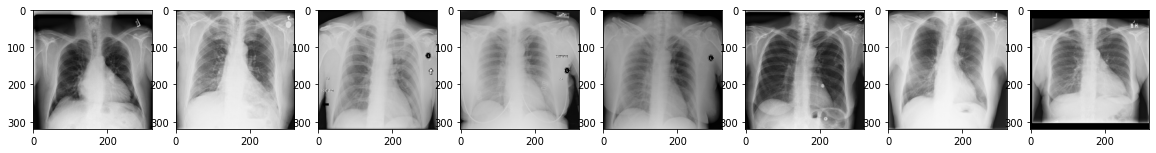

In [12]:
fig, ax = plt.subplots(1,8,figsize=(20,6))
for i in range(8):
  x = load_image(val_gen.filenames[i], IMGDIR, grab_mean_std, preprocess=False)
  ax[i].imshow(x)
print('Original images: (ony resized)')
print(f'image shape: {x1.shape}')
print(f'label shape: {y1.shape}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


validation data generator: (resized + normalized
image shape: (64, 180, 180, 3)
label shape: (64, 14)


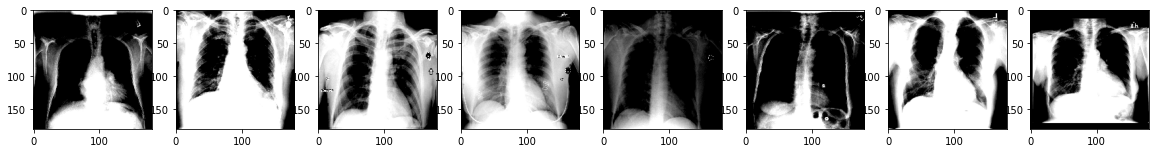

In [13]:
print('validation data generator: (resized + normalized')
print(f'image shape: {x1.shape}')
print(f'label shape: {y1.shape}')
fig, ax = plt.subplots(1,8,figsize=(20,6))
for i in range(8):
  ax[i].imshow(x1[i], cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


validation data generator: (resized + normalized + augmentation + shuffle
image shape: (64, 180, 180, 3)
label shape: (64, 14)


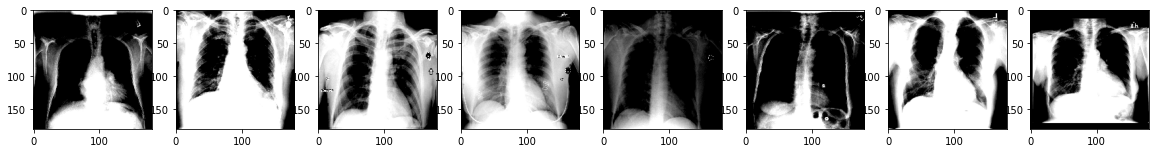

In [14]:
print('validation data generator: (resized + normalized + augmentation + shuffle')
print(f'image shape: {x2.shape}')
print(f'label shape: {y2.shape}')
fig, ax = plt.subplots(1,8,figsize=(20,6))
for i in range(8):
  ax[i].imshow(x1[i], cmap='gray')

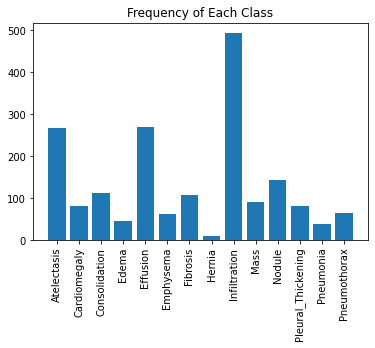

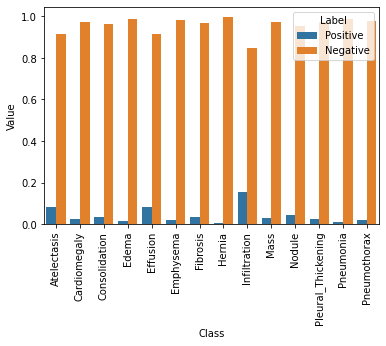

In [15]:
#Deal with class imbalance, the weighted is compensated in the custom loss
plot_class_freq(LABELS, train_gen)
freq_pos, freq_neg = compute_class_freqs(train_gen)
plot_PN_class_ratio(train_gen, LABELS)

We will use the custom loss as ChexNet paper specified :

![title](wloss.jpg)

The wieght will even the contribution between positive and negative samples in each class. 

## 4.Build the model
 Use a pre-trained DenseNet121] model which we can load directly from Keras and then add two layers on top of it:
1. A `GlobalAveragePooling2D` layer to get the average of the last convolution layers from DenseNet121.
2. A `Dense` layer with `sigmoid` activation to get the prediction for each of our classes.

We can set our custom loss function for the model by specifying the `loss` parameter in the `compile()` function.

In [16]:
# create the base pre-trained model
base_model = DenseNet121(weights='imagenet', include_top=False)
x = base_model.output
# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)
# and a logistic layer
predictions = Dense(len(LABELS), activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [0]:
#Compile using custom loss
#'Average AUC' is used for simple check of performance after each epoch 
model.compile(optimizer=Adam(learning_rate=0.001), loss=get_weighted_loss(freq_pos, freq_neg), metrics=['AUC'])

In [0]:
#define callbacks
day = str(date.today())
callbacks = [EarlyStopping(monitor='val_loss', patience=30, verbose=1),
             ModelCheckpoint(f'Model_Weights_{day}.h5', save_best_only=True, save_weights_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_lr=1e-10),
             CSVLogger(f'log_{day}.csv', separator=",", append=False)]

## 5.Start training


In [0]:
#Load previous saved weights
model.load_weights("Model_Weights_2020-05-21.h5")

In [47]:
#start training
model.fit(train_gen, 
                    validation_data=val_gen,
                    steps_per_epoch=N_train/batch_size, 
                    validation_steps=N_val/batch_size, 
                    epochs = 200,
                    callbacks = callbacks)

Epoch 1/200
51/50 [==============================] - 105s 2s/step - loss: 0.7570 - auc: 0.6198 - val_loss: 3.7210 - val_auc: 0.5698 - lr: 0.0010
Epoch 2/200
51/50 [==============================] - 99s 2s/step - loss: 0.6911 - auc: 0.6845 - val_loss: 8.0437 - val_auc: 0.5310 - lr: 0.0010
Epoch 3/200
51/50 [==============================] - 100s 2s/step - loss: 0.6671 - auc: 0.6992 - val_loss: 5.9983 - val_auc: 0.5242 - lr: 0.0010
Epoch 4/200
51/50 [==============================] - 103s 2s/step - loss: 0.6405 - auc: 0.7411 - val_loss: 1.0210 - val_auc: 0.7022 - lr: 0.0010
Epoch 5/200
51/50 [==============================] - 99s 2s/step - loss: 0.6310 - auc: 0.7457 - val_loss: 2.1827 - val_auc: 0.6418 - lr: 0.0010
Epoch 6/200
51/50 [==============================] - 99s 2s/step - loss: 0.6123 - auc: 0.7664 - val_loss: 1.1765 - val_auc: 0.6445 - lr: 0.0010
Epoch 7/200
51/50 [==============================] - 99s 2s/step - loss: 0.6057 - auc: 0.7766 - val_loss: 1.6851 - val_auc: 0.6742 - 

## 6.Testing and Visualization
Using ROC, AUC and GradCAM to check the performance.

  [GradCAM's](https://arxiv.org/abs/1610.02391) technique is to produce a heatmap highlighting the important regions in the image for predicting the pathological condition. 
- This is done by extracting the gradients of each predicted class, flowing into our model's final convolutional layer.  
- GradCAM does not provide a full explanation of the reasoning for each classification probability.
- However, it is still a useful tool for "debugging" our model and augmenting our prediction so that an expert could validate that a prediction is indeed due to the model focusing on the right regions of the image.

Found 967 validated image filenames.


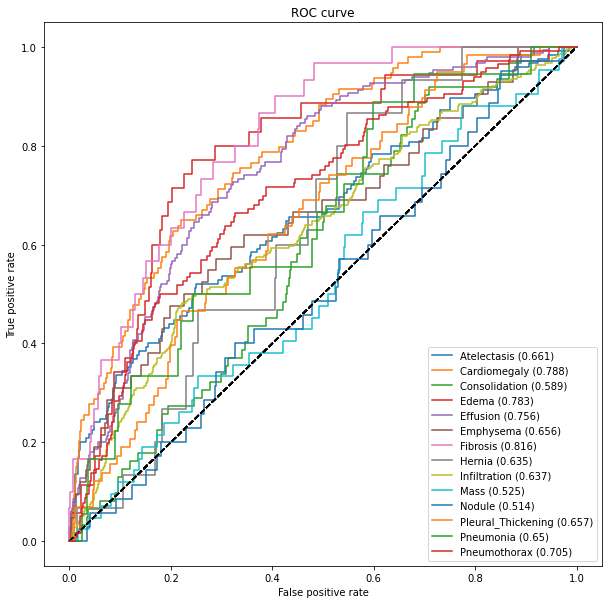

In [20]:
#Testing
test_gen = get_test_generator(df, grab_mean_std, LABELS, IMGDIR, IMG_H, IMG_W)
predicted_vals = model.predict(test_gen, steps = len(test_gen))

#ROC curve
auc_rocs = get_roc_curve(LABELS, predicted_vals, test_gen)

The following table is from ChexNet paper which gives its performance compared to others. Our ROC is not good enough since we only use ~ 3.2k samples for training for demonstration.
![title](compare_chart.jpg)

Loading original image
Generating gradcam for class Cardiomegaly
Generating gradcam for class Edema
Generating gradcam for class Effusion
Generating gradcam for class Fibrosis


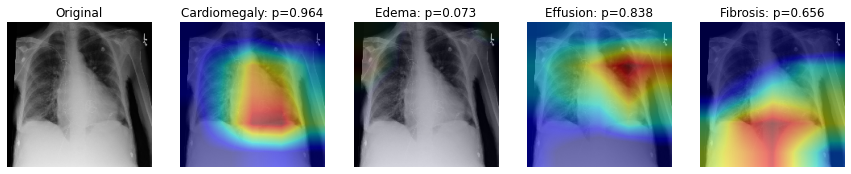

In [28]:
# only show the lables with top 4 AUC
labels_to_show = np.take(LABELS, np.argsort(auc_rocs)[::-1])[:4]
compute_gradcam(model, grab_mean_std, '00000096_001.png', IMGDIR, df, LABELS, labels_to_show)